# Numerical Variables Feature Selection

We perform feature selection for numerical prediction using:
- Linear Regression + RFECV
- RNN + Permutation Importance

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
%matplotlib inline


In [23]:
# Load and prepare data
df_feat = pd.read_pickle('df_feat.pkl')
if 'mood_cat' in df_feat.columns:
    df_feat = df_feat.drop(columns=['mood_cat'])
X = df_feat.drop(columns=['nextday'])
y = df_feat['nextday']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, random_state=42
)


## 1. Linear Regression + RFECV

Select features via recursive elimination and cross-validation.

Optimal # features: 10
Selected: ['activity', 'appCat.communication', 'appCat.utilities', 'call', 'circumplex.valence', 'mood', 'sms', 'screen_log', 'activity_log', 'call_sms_ratio']


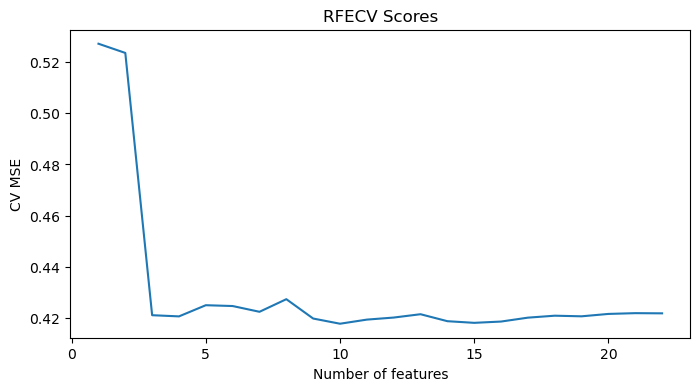

In [18]:
# Pipeline for Linear Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

rfecv = RFECV(
    estimator=pipeline,
    step=1,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    importance_getter=lambda est: np.abs(est.named_steps['lr'].coef_)
)
rfecv.fit(X_train, y_train)
print('Optimal # features:', rfecv.n_features_)
print('Selected:', list(X_train.columns[rfecv.support_]))

# Plot CV MSE vs. # of features
mean_scores = rfecv.cv_results_['mean_test_score']   # these are NEGATIVE MSEs
n_feats = range(1, len(mean_scores) + 1)

plt.figure(figsize=(8,4))
plt.plot(n_feats, -mean_scores)                    # flip sign to get positive MSE
plt.xlabel('Number of features')
plt.ylabel('CV MSE')
plt.title('RFECV Scores')
plt.show()


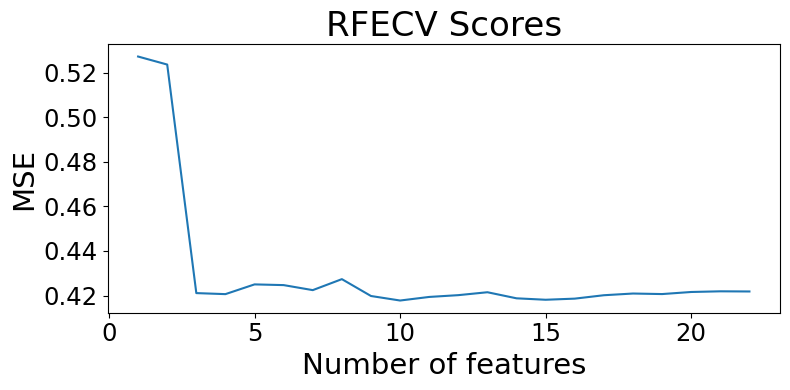

In [32]:
scale = 1.75

plt.figure(figsize=(8,4))
plt.plot(n_feats, -mean_scores)                    # flip sign to get positive MSE
plt.xlabel('Number of features', fontsize=12 * scale)
plt.ylabel('MSE', fontsize=12 * scale)
plt.title('RFECV Scores', fontsize=14 * scale)
plt.xticks(fontsize=10 * scale)
plt.yticks(fontsize=10 * scale)
plt.tight_layout()
plt.savefig('rfecv_scores.pdf', dpi=300)
plt.show()

## 2. RNN + Permutation Importance

Estimate feature importance via permutation on an RNN wrapper.

8/8 [==============================] - 0s 2ms/step


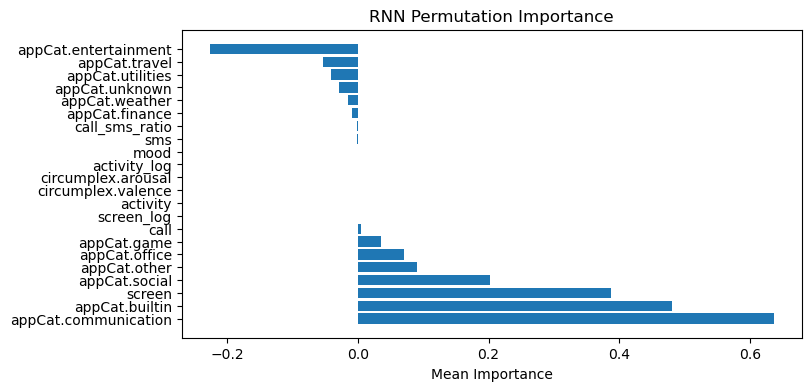

RNN selected features (desc): ['appCat.communication', 'appCat.builtin', 'screen', 'appCat.social', 'appCat.other', 'appCat.office', 'appCat.game', 'call', 'screen_log', 'activity', 'circumplex.valence', 'circumplex.arousal', 'activity_log', 'mood', 'sms', 'call_sms_ratio', 'appCat.finance', 'appCat.weather', 'appCat.unknown', 'appCat.utilities', 'appCat.travel', 'appCat.entertainment']


In [24]:
# Define wrapper for RNN model
class RNNWrapper:
    def __init__(self, build_fn, epochs=20, batch_size=32):
        self.build_fn    = build_fn
        self.epochs      = epochs
        self.batch_size  = batch_size
        self.model_      = None

    def get_params(self, deep=True):
        return {
            'build_fn':   self.build_fn,
            'epochs':     self.epochs,
            'batch_size': self.batch_size
        }

    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self

    def fit(self, X, y):
        X_rnn   = X.values.reshape((len(X),1,X.shape[1]))
        self.model_ = self.build_fn()
        self.model_.fit(X_rnn, y,
                        epochs=self.epochs,
                        batch_size=self.batch_size,
                        verbose=0)
        return self

    def predict(self, X):
        X_rnn = X.values.reshape((len(X),1,X.shape[1]))
        return self.model_.predict(X_rnn).ravel()

        
# Build RNN model function
def build_rnn():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(1, X_train.shape[1]), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Fit RNN wrapper
rnn_wrapper = RNNWrapper(build_rnn, epochs=20, batch_size=32)
rnn_wrapper.fit(X_train, y_train)

# Permutation importance
perm = permutation_importance(
    rnn_wrapper,
    X_test, y_test,
    n_repeats=5,
    random_state=42,
    scoring='neg_mean_squared_error',
    n_jobs=1      # <- force single‑threaded
)

importances = perm.importances_mean
sorted_idx = importances.argsort()[::-1]

# Plot importances
plt.figure(figsize=(8,4))
plt.barh(
    X_train.columns[sorted_idx],
    importances[sorted_idx]
)
plt.xlabel('Mean Importance')
plt.title('RNN Permutation Importance')
plt.show()

print('RNN selected features (desc):', list(X_train.columns[sorted_idx]))


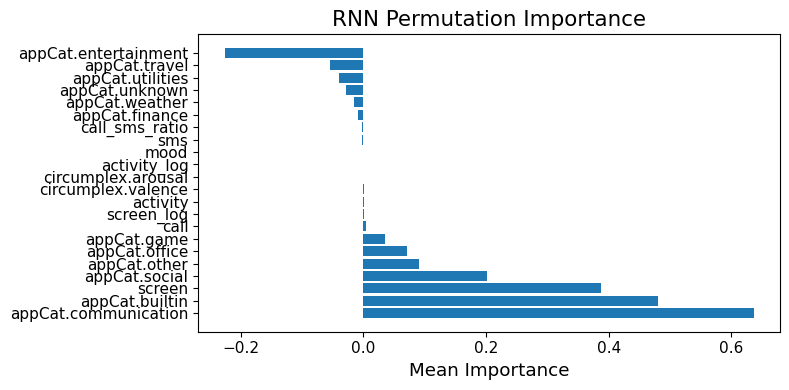

In [30]:
# Plot importances
scale = 1.1

plt.figure(figsize=(8,4))
plt.barh(
    X_train.columns[sorted_idx],
    importances[sorted_idx]
)
plt.xlabel('Mean Importance', fontsize=12 * scale)
plt.title('RNN Permutation Importance', fontsize=14 * scale)
plt.xticks(fontsize=10 * scale)
plt.yticks(fontsize=10 * scale)
plt.tight_layout()
plt.savefig('rnn_permutation_importance.pdf', dpi=300)
plt.show()
